# 1 Установка библиотек

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import os

# 2 Определение гиперпараметров

In [ ]:
#входной размер изображений соответтсвует модели EfficiennetBo
IMG_SIZE = (224, 224)
TRAINING_DIR = "./data/train/"
VALIDATION_DIR = "./data/validation/"
CLASSES = ['bmw_x5', 'land_cruiser', 'qashqai', 'solyaris', 'vaz_2110']

вставить описание контрольных точек
Let's start by creating the ModelCheckpoint callback.
Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [ ]:
# cоздадим callback и место записи логитов
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Создаcоздадим callback  для чекпоинтов, чтобы сохранить модель для последующего использования 
CHECKPOINT_PATH = "./checkpoint/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_weights_only=True, # сохраним только веса модели
                                                         monitor="val_accuracy", # сохранить веса модели, которые обеспечивают наилучшую точность валидации
                                                         save_best_only=True)

# 3 Загрузка данных

ImageDataGenerator...
Creating data loaders (preparing the data)
Now we've downloaded the data, let's use the ImageDataGenerator class along with the flow_from_directory method to load in our images.
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...


In [ ]:
# Загружаем набор изображений с помощью ImageDataGenerator с применением аугментации для тренировочного набора
training_datagen = ImageDataGenerator(rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                        target_size=IMG_SIZE,
                                                        class_mode='categorical',batch_size=32)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                target_size=IMG_SIZE,
                                                                class_mode='categorical',
                                                                shuffle=False,batch_size=32)

Found 130 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


# 4 Создание  и обучение модели

About EfficientNet Models
EfficientNets rely on AutoML and compound scaling to achieve superior performance without compromising resource efficiency. The AutoML Mobile framework has helped develop a mobile-size baseline network, EfficientNet-B0, which is then improved by the compound scaling method to obtain EfficientNet-B1 to B7.


In [ ]:
# Загрузим модель EfficientNetB0, предварительно обученную на наборе Imagenet,
# исключив полносвязный верхинй слой и заморозив для обучения остальные 
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

In [ ]:
# Можем посмотреть состав модели и убедиться, что слои заморожены, а выход модели имеет размерность (None, 7, 7, 1280)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
# Настройка архитектуры модели с обучаемыми верхними слоями
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # форма входного изображения
x = base_model(inputs, training=False) # поместим базовую модель в режим вывода, чтобы мы могли использовать ее для извлечения признаков без обновления весов
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # объединить результаты базовой модели
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Теперь наша модель выглядит так, обучаемых параметров получается в районе 6,5 тыс
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_______________________________________________

In [ ]:
# Компиляция
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_generator,
                                           epochs=40, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/40


2022-03-31 19:26:04.990041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-03-31 19:26:05.629017: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


5/5 [==============================] - 9s 794ms/step - loss: 1.7164 - accuracy: 0.2231 - val_loss: 1.5147 - val_accuracy: 0.3556
Epoch 2/40
5/5 [==============================] - 2s 531ms/step - loss: 1.6353 - accuracy: 0.2692 - val_loss: 1.4182 - val_accuracy: 0.4667
Epoch 3/40
5/5 [==============================] - 2s 526ms/step - loss: 1.4671 - accuracy: 0.3538 - val_loss: 1.3376 - val_accuracy: 0.4889
Epoch 4/40
5/5 [==============================] - 2s 473ms/step - loss: 1.4741 - accuracy: 0.3538 - val_loss: 1.2638 - val_accuracy: 0.6667
Epoch 5/40
5/5 [==============================] - 2s 445ms/step - loss: 1.3167 - accuracy: 0.4692 - val_loss: 1.1993 - val_accuracy: 0.6667
Epoch 6/40
5/5 [==============================] - 2s 524ms/step - loss: 1.2229 - accuracy: 0.5308 - val_loss: 1.1366 - val_accuracy: 0.7111
Epoch 7/40
5/5 [==============================] - 2s 449ms/step - loss: 1.1528 - accuracy: 0.5615 - val_loss: 1.0828 - val_accuracy: 0.7111
Epoch 8/40
5/5 [===============

In [ ]:
# Загрузим веса модели с лучшими показателями val_accuracy так
model.load_weights(CHECKPOINT_PATH)

In [ ]:
# Оценка модели на валидационном наборе данных
results_feature_extraction_model = model.evaluate(validation_generator)
results_feature_extraction_model

2/2 [==============================] - 0s 28ms/step - loss: 0.5713 - accuracy: 0.9111


[0.5713227391242981, 0.9111111164093018]

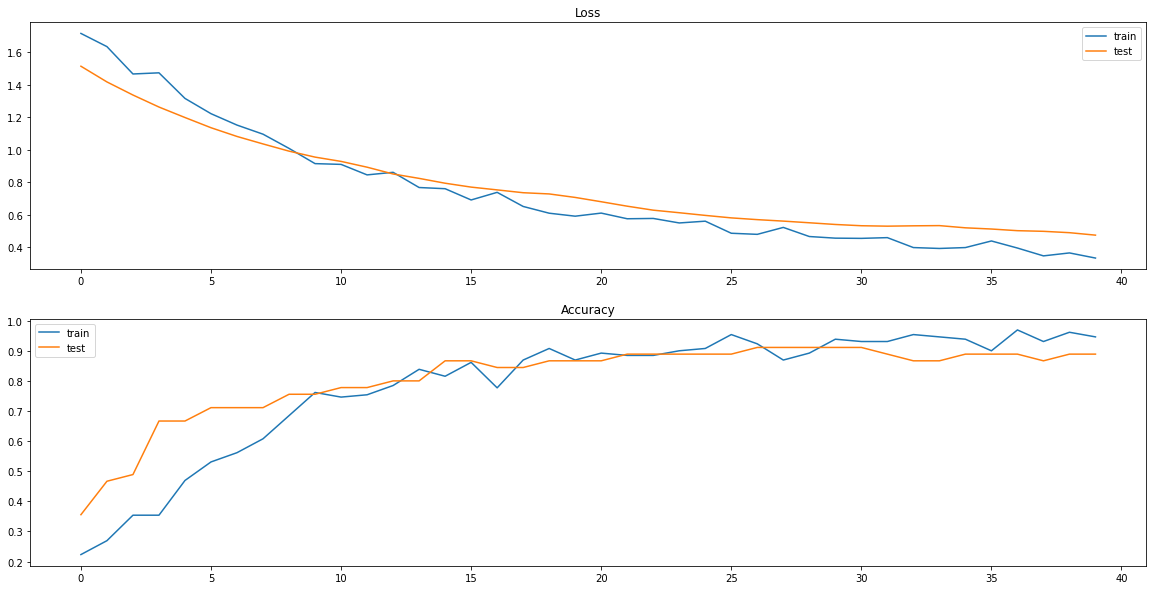

In [ ]:
# График потерь во время обучения
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# График точности во время обучения
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Результаты достаточно неплохие, accuracy выходит на плато  в районе 0,85-0,95, так же можно выделить 
незначительное переобучнение, но мы хотим лучших результатов по этому переходим дальше

# 5 Тонкая настройка

In [ ]:
# Оставим замороженными все слои кроме последних 10, их мы попытаемся обучить вместе с нашей моделью
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_unfreez = tf.keras.Model(inputs, outputs)

In [ ]:
# Вывод модели показывает, что количество обучаемых параметров выросло с 6,5 до 900 тыс. 
# за счет разморозки слоев efficientnetb0
model_unfreez.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
___________________________________________

In [ ]:

# Compile
model_unfreez.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_unfreez = model_unfreez.fit(train_generator,
                                           epochs=30, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                            # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,tensorboard_callback]) # save best model weights to file

/home/cooper/my_projects/my-car-classification/my_env/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/30
5/5 [==============================] - 6s 740ms/step - loss: 1.4737 - accuracy: 0.3692 - val_loss: 1.0528 - val_accuracy: 0.5556
Epoch 2/30
5/5 [==============================] - 2s 482ms/step - loss: 0.8364 - accuracy: 0.7538 - val_loss: 0.8199 - val_accuracy: 0.6889
Epoch 3/30
5/5 [==============================] - 2s 483ms/step - loss: 0.4719 - accuracy: 0.8692 - val_loss: 0.6340 - val_accuracy: 0.7778
Epoch 4/30
5/5 [==============================] - 2s 442ms/step - loss: 0.3235 - accuracy: 0.9538 - val_loss: 0.4658 - val_accuracy: 0.7333
Epoch 5/30
5/5 [==============================] - 2s 464ms/step - loss: 0.2564 - accuracy: 0.9385 - val_loss: 0.3790 - val_accuracy: 0.8444
Epoch 6/30
5/5 [==============================] - 2s 454ms/step - loss: 0.1635 - accuracy: 0.9923 - val_loss: 0.4702 - val_accuracy: 0.8222
Epoch 7/30
5/5 [==============================] - 2s 452ms/step - loss: 0.1586 - accuracy: 0.9692 - val_loss: 0.5468 - val_accuracy: 0.7778
Epoch 8/30
5/5 [====

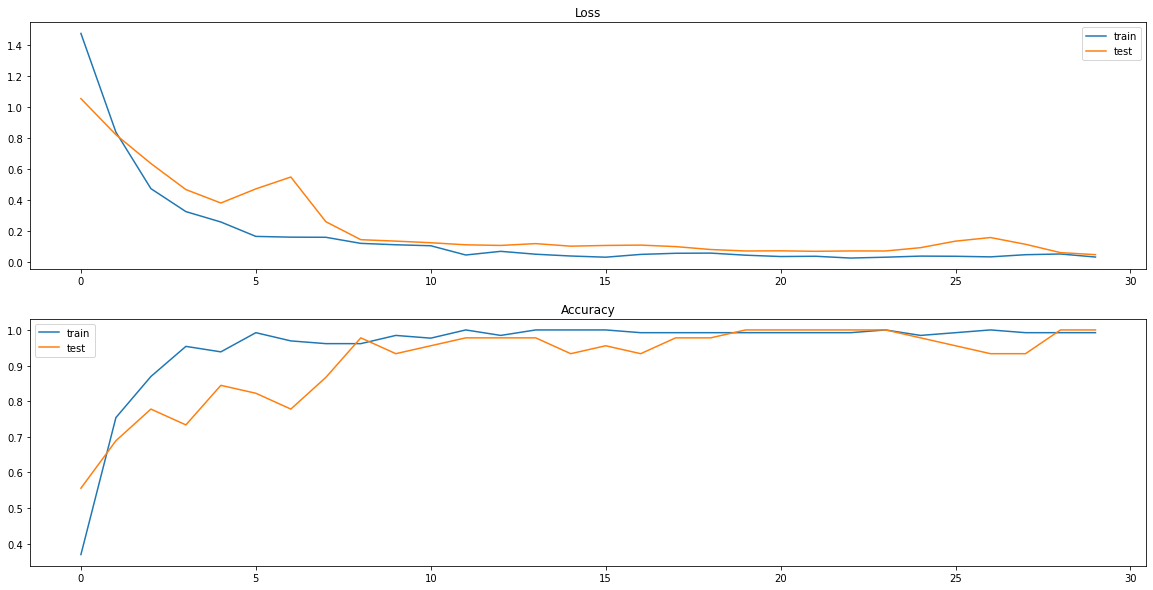

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(211)
plt.title('Loss')
plt.plot(history_unfreez.history['loss'], label='train')
plt.plot(history_unfreez.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history_unfreez.history['accuracy'], label='train')
plt.plot(history_unfreez.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Точность равную 1 мы получили буквально через 10 эпох обучения, далее мы наблюдаем  нестабильные показатели
loss и accuracy на валидационных данных, что может быть вызвано эффектом переобучения, но мы невилируем 
переобученность  модели с помощью загрузки весов полученных при лучшем val_accuracy.

In [ ]:
#загрузим веса модели с наилучшими параметрами val_accuracy за период обучения
model_unfreez.load_weights(CHECKPOINT_PATH)

In [ ]:
# Оценка модели на валидационном наборе данных
results_all_fine_tune = model_unfreez.evaluate(validation_generator)
results_all_fine_tune

2/2 [==============================] - 0s 28ms/step - loss: 0.0694 - accuracy: 1.0000


[0.06935553252696991, 1.0]

# 6 Оценка модели

In [ ]:
# !tensorboard --logdir logs/fit

В tensorboard так же можно смотреть на графики обучения, причем совмещать несколько обучений за раз
![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%20%D0%BE%D1%82%202022-03-30%2020-24-02.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%20%D0%BE%D1%82%202022-03-30%2020-24-02.png)

В tensorboard буквально можно наблюдать как обучались элементы вашей модели на каждой эпохе, это очень может пригодиться при 
качественной оценке каждого слоя модели

![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%20%D0%BE%D1%82%202022-03-30%2020-19-49-2.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%20%D0%BE%D1%82%202022-03-30%2020-19-49-2.png)

В тензорфлоу модель реализуется с помощью графа вычеслений, который автоматически строится и является неким черным ящиком, но благодаря чудесным функциям тенсорбоард мы можем его увидеть:)
# ![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%20%D0%BE%D1%82%202022-03-30%2020-41-59.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%20%D0%BE%D1%82%202022-03-30%2020-41-59.png)


# 7 Получение предсказаний

In [ ]:
def read_img(link):
    img = cv2.imread(link)
    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # resize to 224x224 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224))
    return img

In [ ]:
def predictions_img(link = './data/test/2110.jpeg'):
    # read the image
    img = read_img(link)
    # add a batch dimension in front
    image = np.expand_dims(img, axis=0)
    predictions = model_unfreez.predict(image, verbose=1)
    return predictions

In [ ]:
#При использовании функции актвации softmax на выходе модели получаем вектор из действительных чисел [0,1] 
predictions = predictions_img('./data/test/l3.jpeg')
predictions

1/1 [==============================] - 1s 677ms/step


array([[2.5819796e-03, 9.9222845e-01, 1.2835040e-04, 1.3505749e-04,
        4.9261125e-03]], dtype=float32)

In [ ]:
# Трансформируем векторное представление в предсказанный класс
predict_class = CLASSES[np.argmax(predictions)]
predict_class

'land_cruiser'

In [ ]:
# Ну и собственно исходное изображение с предсказанием
def show(link='./data/test/l4.jpeg'):
    img = cv2.imread(link)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(predict_class)
    plt.show()

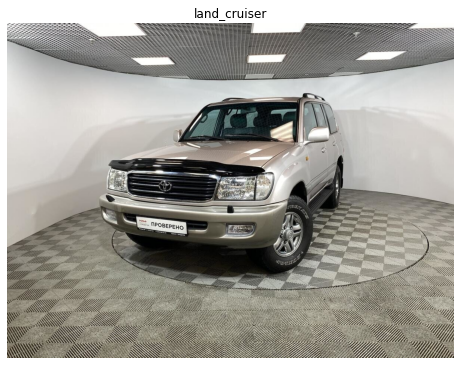

In [ ]:
show('./data/test/l4.jpeg')

#  8 Корреляционная матрица

Вставить описание о кореляционнй матрице

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Переобразуем  валидационные данные из формата ImageDataGenerator в numpy массив. 
# это будет удобно для дальнейшего представления
val_images, val_labels = next(validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=45, shuffle=False))

Found 45 images belonging to 5 classes.


In [ ]:
# Преобразуем выходы софтмакса в целевые значения
pred_probs = np.argmax(model_unfreez.predict(validation_generator, verbose=1), axis=1)
val_labels_true=np.argmax(val_labels, axis=1)

2/2 [==============================] - 1s 62ms/step


In [ ]:
# Создадим корhеляционную матрицу
cm = confusion_matrix(y_true=val_labels_true, y_pred=pred_probs, normalize='true')
cm

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

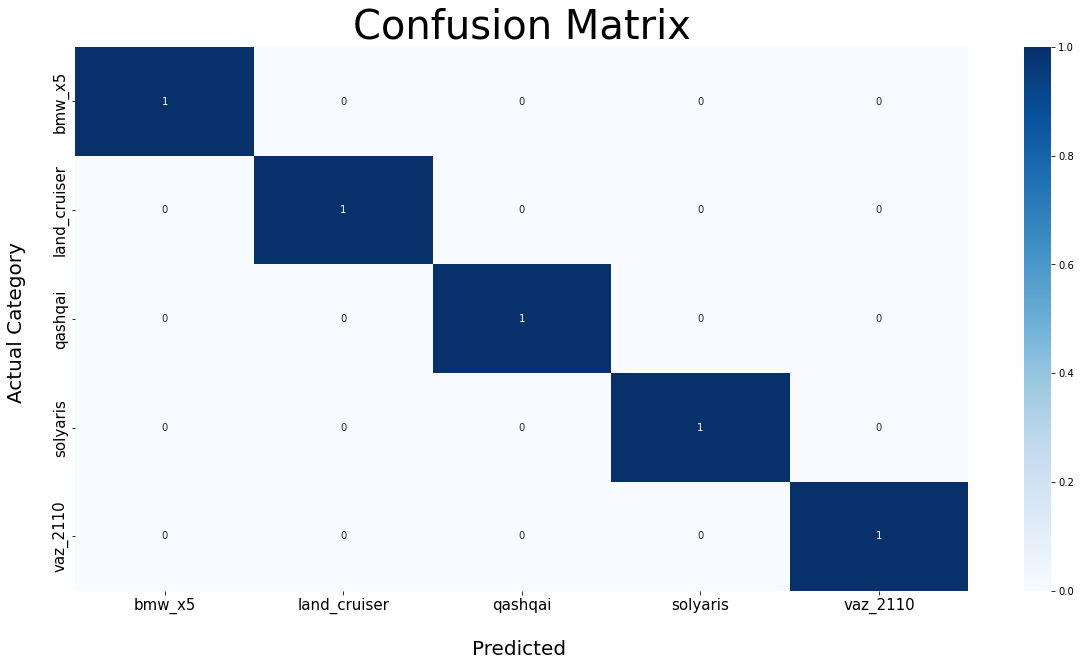

In [ ]:
# Востпользуемся тепловым представлением  корреляционной матрицы с помощью бибилотеки seaborn\
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix',fontsize=40);
ax.set_xlabel('\nPredicted ',fontsize=20)
ax.set_ylabel('Actual Category \n',fontsize=20);

# Ярлыки значений
ax.xaxis.set_ticklabels(CLASSES,fontsize=15)
ax.yaxis.set_ticklabels(CLASSES,fontsize=15)

# Представление матрицы
plt.show()

С учетом того, что точность нашей модели равна 1 мы видим идеальный вариант кореляционной матрицы...

# 9 Saliency map

Еще один из вариантов оценить как работает наша модель ... (вставить из статьи)
https://debuggercafe.com/saliency-maps-in-convolutional-neural-networks/

In [ ]:
# Чтение изображения в numpy массив  размерностью (1, 224, 224, 3) и (224, 224, 3)
def read_img_expand(link):
    # read the image
    img = cv2.imread(link)

    # format it to be in the RGB colorspace
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # resize to 300x300 and normalize pixel values to be in the range [0, 1]
    img = cv2.resize(img, (224, 224)) 

    # add a batch dimension in front
    image_expand = np.expand_dims(img, axis=0)
    return image_expand, img

In [ ]:
# ID класса  нашего изображения
class_index = CLASSES.index('land_cruiser')  #1

# Количество классов в обучающих данных модели
num_classes = 5
image_expand, img = read_img_expand(link='./data/test/l4.jpeg')
# Преоюрзуем в one hot представление, чтобы оно соответствовало нашей активации softmax в определении модели
expected_output = tf.one_hot([class_index] * image_expand.shape[0], num_classes)

with tf.GradientTape() as tape:
    # Преобразуем изображение во  float
    inputs = tf.cast(image_expand, tf.float32)

    # Посмотрим входные пиксели
    tape.watch(inputs)

    # Создадим предсказания
    predictions = model_unfreez(inputs)

    # Получим loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# Получим градиент относительно входных данных
gradients = tape.gradient(loss, inputs)

In [ ]:
# Уменьшим изображение RGB до оттенков серого
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# Нормализуем значения пикселей градиента, чтобы они находились в диапазоне [0, 255].
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

#  Преобразуем в двумерный тензор
normalized_tensor = tf.squeeze(normalized_tensor)

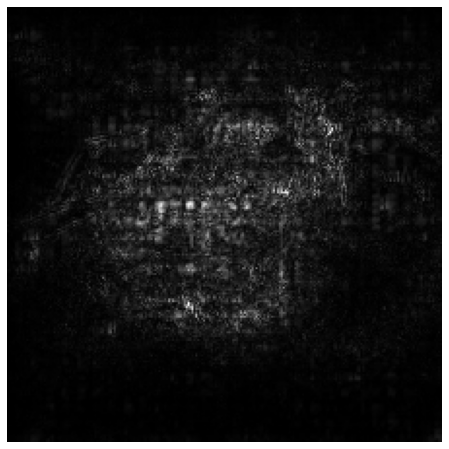

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()


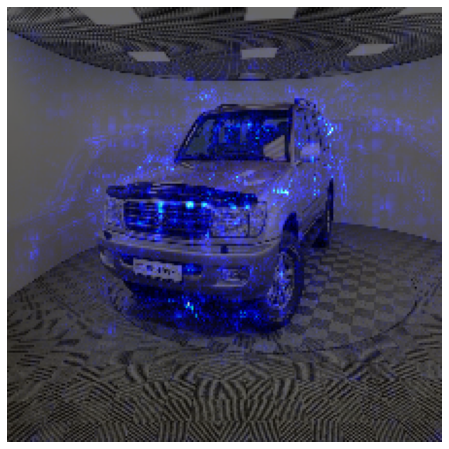

In [ ]:
# Совместим исходное изображение с изображением градиента
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
super_imposed = cv2.addWeighted(img, 0.4, gradient_color, 0.8, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

# 10 Сохранение модели

In [ ]:
# Save the entire model as a models/model/1
MODEL_DIR = "models"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)